# Gerekli Kütüphaneler

In [1]:
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafaerengulbahar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Veriyi Okuma

In [2]:
# Buradan datayı okuyoruz
df = pd.read_excel("data/tweets.xlsx")
df.head()

,Görüş,Durum
0,Cumhuriyetin 100. Yılı x Filenin Sultanları\n...,Olumlu
1,Olimpiyat altınımız olacak!!,Olumlu
2,Keşke Fenerbahçe -Galatasaray süper kupa maçı ...,Olumlu
3,Sacmalaama olimpiyat yılı fjejsjdj hem gui ile...,Olumlu
4,Geçen sene bilmem de bu sene yedeğe asla geçme...,Olumlu


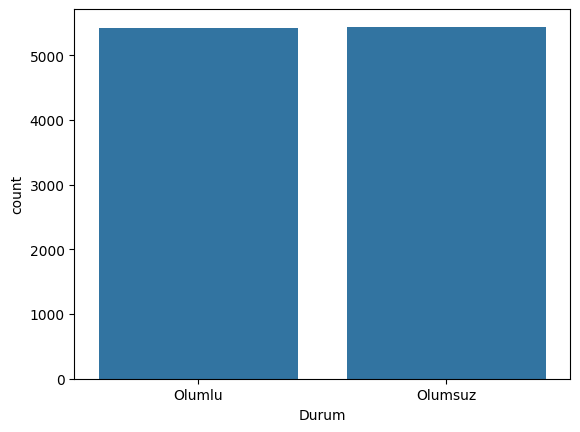

In [3]:
# Burada olumlu ve olumsuz metinlerin yoğunluklarını görüyoruz
sns.countplot(x = df.Durum);

# Veri Ön İşleme

In [9]:
# Burada olumlu ve olumsuz etiketli verileri 1 ve 0 olacak şekilde etiketliyoruz
sent_dict = {'Olumsuz': 0, 'Olumlu': 1}

df['Durum'] = df['Durum'].map(sent_dict)
df.head()

,Görüş,Durum
0,Ürün gayet güzel boyutları dört kişilik aile ...,1
1,Ürünü kullandım gayet memnunum,1
2,Hızlı kargo,1
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0
4,ürün fena değil ancak gövdenin plastik olması ...,1


In [10]:
# Burada veri üzerinde ön işleme yapıyoruz
def clean_text(text):

    unwanted_pattern = r'[!.\n,:“”,?@#"]'
    regex = re.compile(unwanted_pattern)
    cleaned_text = regex.sub(" ", text)
    
    return cleaned_text

df['new_text'] = df['Görüş'].astype(str).apply(clean_text)
df['new_text'] = df['new_text'].str.replace("[\d]", "")
df['new_text'] = df['new_text'].str.lower()

df.head()

<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\erenn\AppData\Local\Temp\ipykernel_14504\3724318612.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['new_text'] = df['new_text'].str.replace("[\d]", "")


,Görüş,Durum,new_text
0,Ürün gayet güzel boyutları dört kişilik aile ...,1,ürün gayet güzel boyutları dört kişilik aile ...
1,Ürünü kullandım gayet memnunum,1,ürünü kullandım gayet memnunum
2,Hızlı kargo,1,hızlı kargo
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0,8 yıl önce lg 42 lm serisi almıştım ve tv den ...
4,ürün fena değil ancak gövdenin plastik olması ...,1,ürün fena değil ancak gövdenin plastik olması ...


In [11]:
# Değer olmayan verileri tablodan siliyoruz
df = df.dropna()
df.isna().sum()

Görüş       0
Durum       0
new_text    0
dtype: int64

In [12]:
# Burada bazı gereksiz kelimeri silmek için NLTK kütüphanesinden stopwords fonksiyonunu kullanıyoruz. Bazı gereksiz kelimeri gösterelim.
ineffective = stopwords.words('turkish')
ineffective[:5]

['acaba', 'ama', 'aslında', 'az', 'bazı']

In [13]:
df['new_text'] = df['new_text'].apply(lambda x: " ".join(x for x in x.split() if x not in ineffective))

df.head()

,Görüş,Durum,new_text
0,Ürün gayet güzel boyutları dört kişilik aile ...,1,ürün gayet güzel boyutları dört kişilik aile y...
1,Ürünü kullandım gayet memnunum,1,ürünü kullandım gayet memnunum
2,Hızlı kargo,1,hızlı kargo
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0,8 yıl önce lg 42 lm serisi almıştım tv den gay...
4,ürün fena değil ancak gövdenin plastik olması ...,1,ürün fena değil ancak gövdenin plastik olması ...


In [15]:
# Yapılan ön işlemli dataframe'yi kaydedelim
df.to_csv("data/tweets2.csv")

In [49]:
# TF-IDF'yi metindeki bir kelimenin önemini ölçmek için kullanıyoruz. Böylece bir kelimenin cümledeki sıklık değeri metnin tamamındaki sıklık değerine bölünerek o sözcüğe bir ağırlık değeri verilir.
# CountVectorizer, bir metindeki her kelimenin geçiş sayısını sayarak bir dağılım matrisi oluşturur.Bu matriste, her kelime bir sütun ve her metin bir satırdır.
X_train, X_test, y_train, y_test = train_test_split(df['new_text'], df['Durum'], test_size=0.2, random_state=42)

tf_vector = TfidfVectorizer(max_features =  5000)
ct_vector = CountVectorizer(max_features = 5000)

#X = tf_vector.fit_transform(df['new_text'])
#Y = df['sentiment']

X_train_vec = tf_vector.fit_transform(X_train)
X_test_vec = tf_vector.transform(X_test)
X_train_ct = ct_vector.fit_transform(X_train)
X_test_ct = ct_vector.transform(X_test)

# Makine Öğrenmesi Modelleri

## Naive Bayes

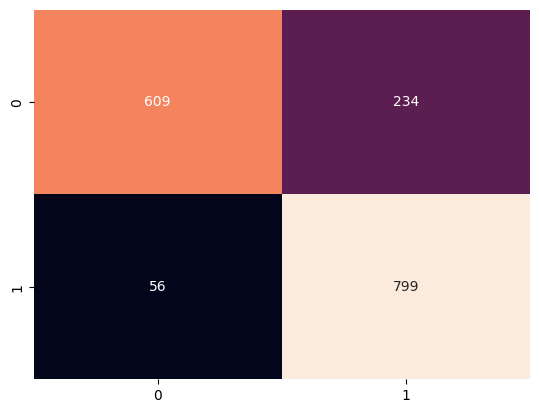

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       843
           1       0.77      0.93      0.85       855

    accuracy                           0.83      1698
   macro avg       0.84      0.83      0.83      1698
weighted avg       0.84      0.83      0.83      1698



In [50]:
nb_tf = BernoulliNB()
nb_tf.fit(X_train_vec, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test, y_pred))
    
result = pd.DataFrame(columns=['TF_Vectorizer_accuracy', 'Count_Vectorizer_accuracy', 'Model'])
    
evaluate_model(nb_tf, X_test_vec, y_test)

# Precision (Hassasiyet): Pozitif olarak tahmin edilen örnekler arasında gerçekten pozitif olanların oranı.
# Recall (Duyarlılık veya yeniden çağırma): Gerçek pozitif örneklerin, pozitif olarak doğru tahmin edilenlerle oranı.
# F1-Score: Hassasiyet ve duyarlılığın harmonik ortalaması. Dengeli bir metrik olup, her iki değeri de dikkate alır.
# Support (Destek): Her sınıftaki gerçek örnek sayısı.

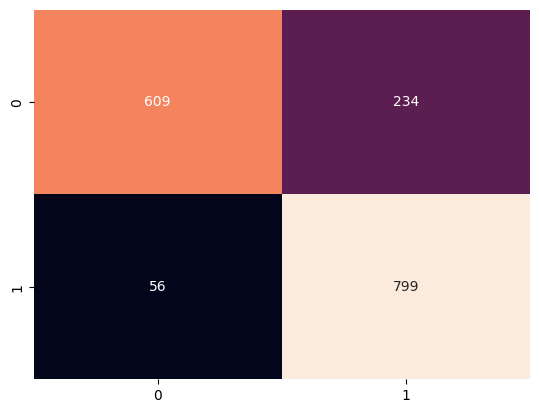

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       843
           1       0.77      0.93      0.85       855

    accuracy                           0.83      1698
   macro avg       0.84      0.83      0.83      1698
weighted avg       0.84      0.83      0.83      1698



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.829,0.829,Naive Bayes


In [51]:
nb_ct = BernoulliNB()
nb_ct.fit(X_train_ct, y_train)

new_row = pd.DataFrame({
    'Model': ['Naive Bayes'],
    'Count_Vectorizer_accuracy': [nb_ct.score(X_test_ct, y_test)],
    'TF_Vectorizer_accuracy': [nb_tf.score(X_test_vec, y_test)]
})

evaluate_model(nb_ct, X_test_ct, y_test)
result = pd.concat([result, new_row], ignore_index=True)

result

## Support Vector Machine (SVM)

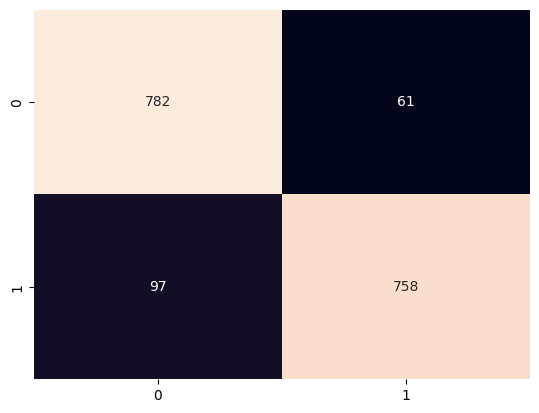

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       843
           1       0.93      0.89      0.91       855

    accuracy                           0.91      1698
   macro avg       0.91      0.91      0.91      1698
weighted avg       0.91      0.91      0.91      1698



In [52]:
svc_tf = SVC()
svc_tf.fit(X_train_vec, y_train)
evaluate_model(svc_tf, X_test_vec, y_test)

# Precision (Hassasiyet): Pozitif olarak tahmin edilen örnekler arasında gerçekten pozitif olanların oranı.
# Recall (Duyarlılık veya yeniden çağırma): Gerçek pozitif örneklerin, pozitif olarak doğru tahmin edilenlerle oranı.
# F1-Score: Hassasiyet ve duyarlılığın harmonik ortalaması. Dengeli bir metrik olup, her iki değeri de dikkate alır.
# Support (Destek): Her sınıftaki gerçek örnek sayısı.

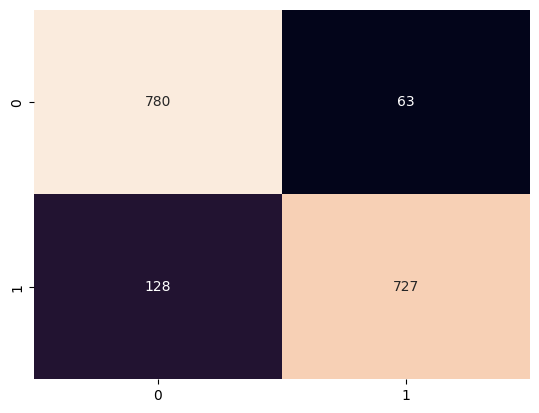

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       843
           1       0.92      0.85      0.88       855

    accuracy                           0.89      1698
   macro avg       0.89      0.89      0.89      1698
weighted avg       0.89      0.89      0.89      1698



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.829,0.829,Naive Bayes
1,0.907,0.888,Support Vector Machine


In [53]:
svc_ct = SVC()
svc_ct.fit(X_train_ct, y_train)
evaluate_model(svc_ct, X_test_ct, y_test)

new_row_svc = pd.DataFrame({
    'Model': ['Support Vector Machine'],
    'Count_Vectorizer_accuracy': [svc_ct.score(X_test_ct, y_test)],
    'TF_Vectorizer_accuracy': [svc_tf.score(X_test_vec, y_test)]
})

result = pd.concat([result, new_row_svc], ignore_index=True)
result

## XGBOOST

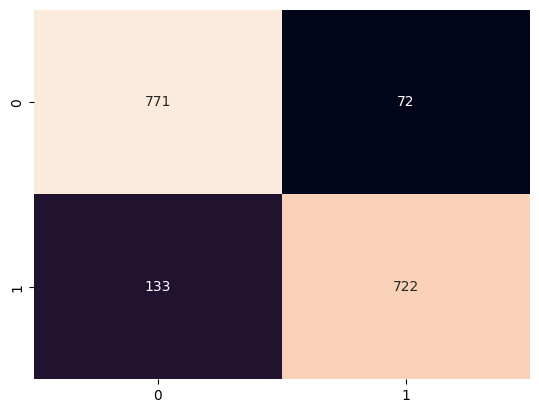

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       843
           1       0.91      0.84      0.88       855

    accuracy                           0.88      1698
   macro avg       0.88      0.88      0.88      1698
weighted avg       0.88      0.88      0.88      1698



In [54]:
xb_tf = XGBClassifier()
xb_tf.fit(X_train_vec, y_train)
evaluate_model(xb_tf, X_test_vec, y_test)

# Precision (Hassasiyet): Pozitif olarak tahmin edilen örnekler arasında gerçekten pozitif olanların oranı.
# Recall (Duyarlılık veya yeniden çağırma): Gerçek pozitif örneklerin, pozitif olarak doğru tahmin edilenlerle oranı.
# F1-Score: Hassasiyet ve duyarlılığın harmonik ortalaması. Dengeli bir metrik olup, her iki değeri de dikkate alır.
# Support (Destek): Her sınıftaki gerçek örnek sayısı.

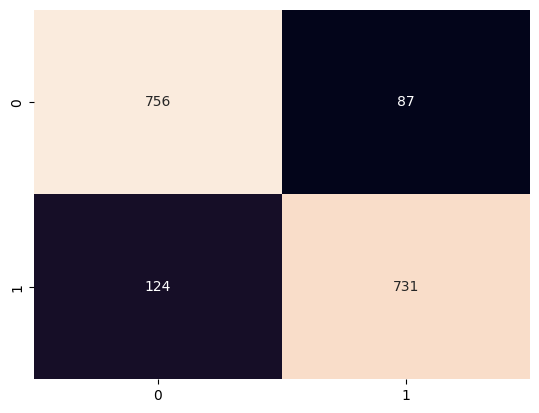

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       843
           1       0.89      0.85      0.87       855

    accuracy                           0.88      1698
   macro avg       0.88      0.88      0.88      1698
weighted avg       0.88      0.88      0.88      1698



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.829,0.829,Naive Bayes
1,0.907,0.888,Support Vector Machine
2,0.879,0.876,XGBOOST


In [55]:
xb_ct = XGBClassifier()
xb_ct.fit(X_train_ct, y_train)
evaluate_model(xb_ct, X_test_ct, y_test)

new_row_xb = pd.DataFrame({
    'Model': ['XGBOOST'],
    'Count_Vectorizer_accuracy': [xb_ct.score(X_test_ct, y_test)],
    'TF_Vectorizer_accuracy': [xb_tf.score(X_test_vec, y_test)]
})

result = pd.concat([result, new_row_xb], ignore_index=True)

result

## CATBOOST

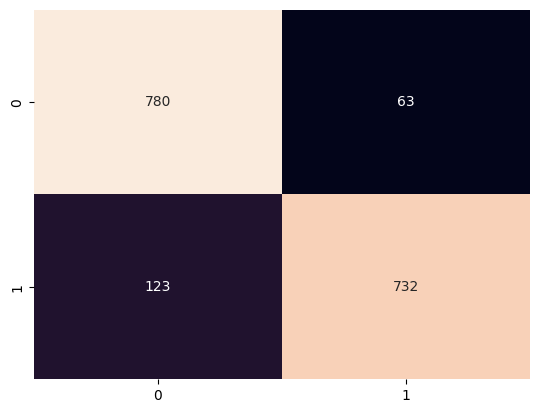

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       843
           1       0.92      0.86      0.89       855

    accuracy                           0.89      1698
   macro avg       0.89      0.89      0.89      1698
weighted avg       0.89      0.89      0.89      1698



In [56]:
cb_tf = CatBoostClassifier()
cb_tf.fit(X_train_vec, y_train, verbose = 0)
evaluate_model(cb_tf, X_test_vec, y_test)

# Precision (Hassasiyet): Pozitif olarak tahmin edilen örnekler arasında gerçekten pozitif olanların oranı.
# Recall (Duyarlılık veya yeniden çağırma): Gerçek pozitif örneklerin, pozitif olarak doğru tahmin edilenlerle oranı.
# F1-Score: Hassasiyet ve duyarlılığın harmonik ortalaması. Dengeli bir metrik olup, her iki değeri de dikkate alır.
# Support (Destek): Her sınıftaki gerçek örnek sayısı.

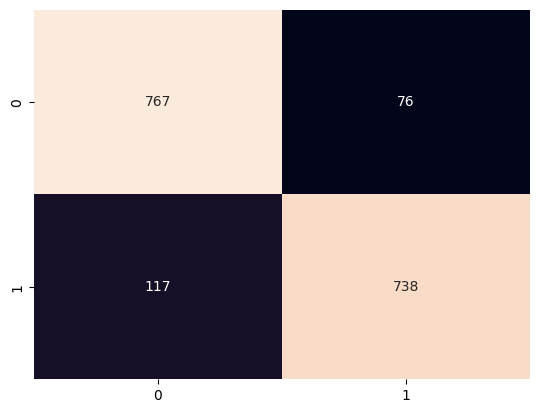

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       843
           1       0.91      0.86      0.88       855

    accuracy                           0.89      1698
   macro avg       0.89      0.89      0.89      1698
weighted avg       0.89      0.89      0.89      1698



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.829,0.829,Naive Bayes
1,0.907,0.888,Support Vector Machine
2,0.879,0.876,XGBOOST
3,0.890,0.886,CATBOOST


In [57]:
cb_ct = CatBoostClassifier()
cb_ct.fit(X_train_ct, y_train, verbose=0)
evaluate_model(cb_ct, X_test_ct, y_test)

new_row_cb = pd.DataFrame({
    'Model': ['CATBOOST'],
    'Count_Vectorizer_accuracy': [cb_ct.score(X_test_ct, y_test)],
    'TF_Vectorizer_accuracy': [cb_tf.score(X_test_vec, y_test)]
})

result = pd.concat([result, new_row_cb], ignore_index=True)
result

# Derin Öğrenme Modelleri

## ANN

In [58]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizer'ı yarat və train datasını tokenize et
# Create Tokenizer and tokenize train data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df["Görüş"])

# Tokenize edilmiş dataları tamamla (padding et)
# Padding tokenized data
maxlen = 200
X_train_dl = pad_sequences(tokenizer.texts_to_sequences(train_df["Görüş"]), maxlen=maxlen)
X_test_dl = pad_sequences(tokenizer.texts_to_sequences(test_df["Görüş"]), maxlen=maxlen)

y_train = train_df["Durum"].values
y_test = test_df["Durum"].values

In [59]:
tf.random.set_seed(42)

ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape = (X_train_dl.shape[1], )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

ann_model.summary()

C:\Users\erenn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,049 (133.00 KB)

 Trainable params: 34,049 (133.00 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

In [61]:
history_ann = ann_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test), epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5455 - loss: 64.2969 - val_accuracy: 0.5383 - val_loss: 26.5269
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5818 - loss: 23.4662 - val_accuracy: 0.5312 - val_loss: 20.3819
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.6049 - loss: 11.6467 - val_accuracy: 0.5618 - val_loss: 15.1820
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 7.2458 - val_accuracy: 0.5707 - val_loss: 12.5322
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6546 - loss: 5.5375 - val_accuracy: 0.5677 - val_loss: 12.5433
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6556 - loss: 4.8900 - val_accuracy: 0.5807 - val_loss: 10.7873
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6796 - loss: 3.3897 - val_accuracy: 0.5683 - val_loss: 10.3717
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6815 - loss: 3.1812 - va

In [62]:
def evaluate_model_dl(model, X_test, y_test):
    y_pred = (model.predict(X_test_dl) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test, y_pred))
    
result_dl = pd.DataFrame(columns=['Accuracy', 'Model'])

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


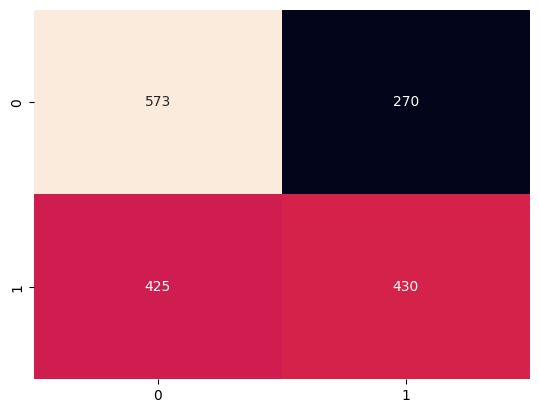

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       843
           1       0.61      0.50      0.55       855

    accuracy                           0.59      1698
   macro avg       0.59      0.59      0.59      1698
weighted avg       0.59      0.59      0.59      1698



In [63]:
evaluate_model_dl(ann_model, X_test_dl, y_test)

# Precision (Hassasiyet): Pozitif olarak tahmin edilen örnekler arasında gerçekten pozitif olanların oranı.
# Recall (Duyarlılık veya yeniden çağırma): Gerçek pozitif örneklerin, pozitif olarak doğru tahmin edilenlerle oranı.
# F1-Score: Hassasiyet ve duyarlılığın harmonik ortalaması. Dengeli bir metrik olup, her iki değeri de dikkate alır.
# Support (Destek): Her sınıftaki gerçek örnek sayısı.

In [64]:
# ANN model değerlendirmesi (ann_model ve X_test_dl, y_test zaten tanımlanmış olmalı)
accuracy_ann = ann_model.evaluate(X_test_dl, y_test)[1]  # Modelin doğruluk skorunu almak için

new_row_ann = pd.DataFrame({
    'Model': ['ANN'],
    'Accuracy': [accuracy_ann]
})

result_dl = pd.concat([result_dl, new_row_ann], ignore_index=True)
result_dl

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.5825 - loss: 9.5033


,Accuracy,Model
0,0.591,ANN


## Embeding

In [65]:
tf.random.set_seed(42)

em_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 16, input_length=maxlen),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

em_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

em_model.summary()

C:\Users\erenn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
history_em = em_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test), epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6583 - loss: 0.6620 - val_accuracy: 0.8681 - val_loss: 0.3693
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8731 - loss: 0.3325 - val_accuracy: 0.8946 - val_loss: 0.2742
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.2219 - val_accuracy: 0.8993 - val_loss: 0.2540
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9456 - loss: 0.1646 - val_accuracy: 0.9081 - val_loss: 0.2475
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.1226 - val_accuracy: 0.9093 - val_loss: 0.2504
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0920 - val_accuracy: 0.9052 - val_loss: 0.2574


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


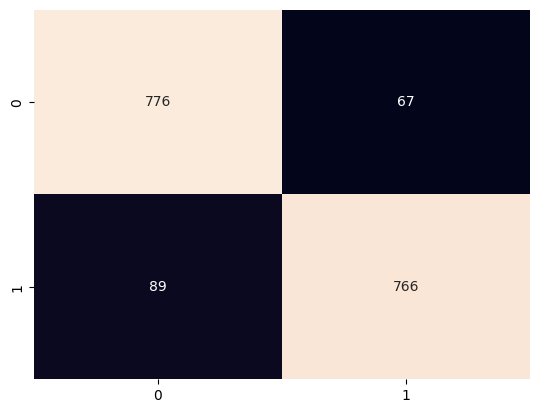

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       843
           1       0.92      0.90      0.91       855

    accuracy                           0.91      1698
   macro avg       0.91      0.91      0.91      1698
weighted avg       0.91      0.91      0.91      1698



In [67]:
evaluate_model_dl(em_model, X_test_dl, y_test)

# Precision (Hassasiyet): Pozitif olarak tahmin edilen örnekler arasında gerçekten pozitif olanların oranı.
# Recall (Duyarlılık veya yeniden çağırma): Gerçek pozitif örneklerin, pozitif olarak doğru tahmin edilenlerle oranı.
# F1-Score: Hassasiyet ve duyarlılığın harmonik ortalaması. Dengeli bir metrik olup, her iki değeri de dikkate alır.
# Support (Destek): Her sınıftaki gerçek örnek sayısı.

In [68]:
# Embedding modelin değerlendirilmesi
accuracy_embedding = em_model.evaluate(X_test_dl, y_test)[1]  # Modelin doğruluk skorunu almak için

new_row_embedding = pd.DataFrame({
    'Model': ['Embedding'],
    'Accuracy': [accuracy_embedding]
})

result_dl = pd.concat([result_dl, new_row_embedding], ignore_index=True)

result_dl

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9173 - loss: 0.2307


,Accuracy,Model
0,0.591,ANN
1,0.908,Embedding


## CNN

In [69]:
tf.random.set_seed(42)

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 16, input_length=maxlen),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_model.summary()

C:\Users\erenn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
history_cnn = cnn_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test), epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6870 - loss: 0.5844 - val_accuracy: 0.8940 - val_loss: 0.2651
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9155 - loss: 0.2251 - val_accuracy: 0.9011 - val_loss: 0.2567


In [71]:
# CNN modelin değerlendirilmesi, evaluate_model_dl fonksiyonunu tanımlayıp burada kullanmadığınız sürece
accuracy_cnn = cnn_model.evaluate(X_test_dl, y_test)[1]  # Modelin doğruluk skorunu almak için

new_row_cnn = pd.DataFrame({
    'Model': ['CNN'],
    'Accuracy': [accuracy_cnn]
})

result_dl = pd.concat([result_dl, new_row_cnn], ignore_index=True)

result_dl

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9105 - loss: 0.2398


,Accuracy,Model
0,0.591,ANN
1,0.908,Embedding
2,0.894,CNN


## LSTM

In [72]:
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 16, input_length=maxlen),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()

C:\Users\erenn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
history_lstm = lstm_model.fit(X_train_dl, y_train, validation_data=(X_test_dl, y_test), epochs= 20, batch_size=32, callbacks = [early_stopping])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6429 - loss: 0.6003 - val_accuracy: 0.8958 - val_loss: 0.2587
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9164 - loss: 0.2186 - val_accuracy: 0.9028 - val_loss: 0.2490


In [74]:
accuracy_lstm = lstm_model.evaluate(X_test_dl, y_test)[1]  # Modelin doğruluk skorunu almak için

new_row_lstm = pd.DataFrame({
    'Model': ['LSTM'],
    'Accuracy': [accuracy_lstm]
})

result_dl = pd.concat([result_dl, new_row_lstm], ignore_index=True)

result_dl

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9044 - loss: 0.2344


,Accuracy,Model
0,0.591,ANN
1,0.908,Embedding
2,0.894,CNN
3,0.896,LSTM


# Test

In [ ]:
# Yukarıdaki tablolarda baktığımızda en iyi modeller Support Vector Machine ve LSTM oldu.
# Dolayısıyla bu iki modeller üzerinde testler yapıyoruz.

predict_dict = {0: 'Olumsuz', 1: 'Olumlu'}

while True:
    text = str(input('\n Write your message: '))
    
    if text == 'break':
        break
    
    ml_token = tf_vector.transform([text])
    pred_ml = svc_tf.predict(ml_token)[0]
    dl_token = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = 200)
    pred_dl = (lstm_model.predict(dl_token) > 0.5).astype(int)[0][0]
    
    print(f'Support Vector Machine (SVM) Tahmini = > {predict_dict[pred_ml]}\nLSTM Tahmini = > {predict_dict[pred_dl]}')

In [84]:
# Save SVM model
with open('svm_model.pkl','wb') as f:
    pickle.dump(svc_tf,f)

In [85]:
# Save LSTM model
lstm_model.save("lstm_model.keras")